## 1.模型建立
尝试建立一个神经网络模型通过往年来首次获奖的国家所具有的特征来进行拟合

设$X=[x_1,x_2,x_3]$其中，
| Symbols | meaning                          |
|---------|----------------------------------|
| $x_1$   | 此届国家自参赛以来未有获奖的届数 |
| $x_2$   | 此届国家拥有的运动员数量         |
| $x_3$   | 此届的平均奖牌数量               |

将$X$作为输入层，设立隐藏层为2层，神经元数量分别为4，3，输出层神经元数量为1表示获奖概率

$y$表示下一届是否得奖$y=0 \quad or \quad 1$

## 2.模型求解

### 2.1 数据准备
通过官网所提供的文件进行处理，得到样本，并按照0.2的比例作为测试集与训练集之比。

### 2.2 神经网络框架构建
$a^{(i)}$表示第$i$层的激活值。

$a^{(2)}=g(\Theta^{(1)}X)$

$a^{(3)}=g(\Theta^{(2)}a^{(2)})$

$a^{(4)}=g(\Theta^{(3)}a^{(3)})$

$\hat y=a^{(4)}$

其中$\Theta^{(i)}$表示传播矩阵，$g$表示激活函数，这里使用$sigmod$函数作为激活函数输出范围为$(0,1)$

### 2.2 损失函数
使用二分类的交叉熵损失函数来衡量预测值$\hat y$与真实值$y$的误差
$$
J(\Theta)=-\frac{1}{n}\sum^n_{i=1}[y^{(i)}log(\hat y^{(i)})+(1-\hat y^{i})]
$$
### 2.3 问题转化
则该模型的学习过程可以转化为使损失函数最小化的过程，即通过样本学习让参数进行优化

### 2.4 参数优化
#### 2.4.1 优化方法
使用梯度下降法优化损失函数，通过遍历每一个样本使用反向传播计算梯度得到$\frac{\partial J}{\partial \Theta^{(i)}_{jk}}$
设$\eta$为学习率
则
$$
\Theta^{(i)}_{jk}:= \Theta^{(i)}_{jk}-\eta \frac{\partial J}{\partial \Theta^{(i)}_{jk}}
$$
由于梯度下降法需要重复计算大量的样本后求出平均值，为了提高算法性能，我们采用分组平均的方式进行下降，设$m$为样本将会被分成的组数。每一次迭代都迭代每一组，通过每一组的平均梯度进行下降。

#### 2.4.2 模型训练
主要步骤如下表格所示：
| Step  | Method                                                                                |
|-------|---------------------------------------------------------------------------------------|
| step1 | 初始化参数$\Theta^{(1)},\Theta^{(2)},\Theta^{(3)}$以及最大迭代次数epochs以及分组数$m$ |
| step2 | 前向传播计算$a^{(2)},a^{(3)},a^{(4)}$                                                 |
| step3 | 按照$m$作为分组数量进行样本分组                                                       |
| step4 | 对于每个样本组通过反向传播法计算每个参数的梯度                                        |
| step5 | 得到每个样本组的平均梯度后对每个参数进行梯度下降直到所有组迭代结束                    |
| step6 | 记录迭代后的损失函数值                                                                |
| step7 | 判断是否满足最大迭代次数，满足则停止训练否则重复step2至step7                          |



## 3.模型检验
通过训练的模型，观察学习曲线以及准确率曲线得到其拟合效果如下：
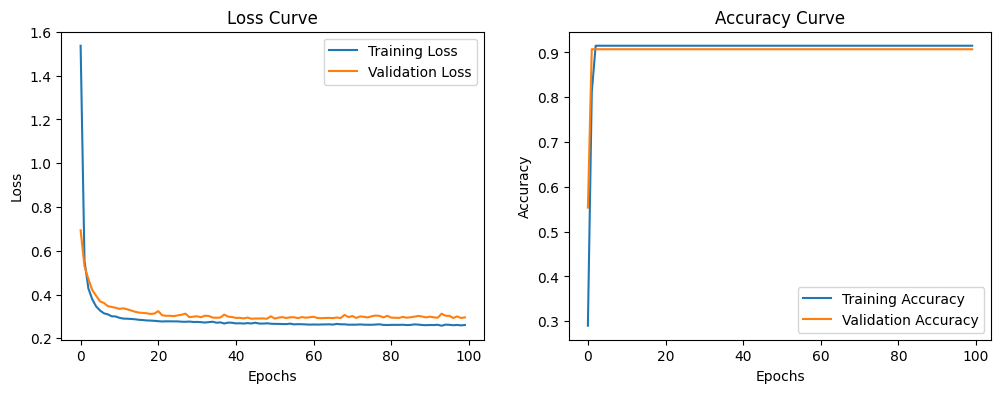

可见该模型训练的分类器具有较高的准确率与较低的损失值

## 1.Model Construction
Attempt to Build a Neural Network Model 

A neural network model is constructed to fit the characteristics of countries that have won their first medal in past years.

Let $X=[x_1,x_2,x_3]$ Here ，
| Symbols | meaning                          |
|---------|----------------------------------|
| $x_1$   | The number of editions in which the country has participated without winning any medals since its first participation. |
| $x_2$   | The number of athletes the country has in this edition        |
| $x_3$   | The average number of medals awarded in this edition.               |


Use $X$ as the input layer, establish two hidden layers with 4 and 3 neurons respectively, and set the output layer with 1 neuron to represent the probability of winning a medal.

$y$ represents whether a medal is won in the next edition, where $y=0$ indicates no medal,and $y=1$ indicates a medal is won.

## 2.Model Solution

### 2.1 Data Preparation
The dataset is processed based on the files provided on the official website. The samples are split into training and testing sets with a ratio of 0.2.

The flowchart of sample data preparation is represented as follows.

![C_2data initialization.png](<attachment:C_2data initialization.png>)

### 2.2 Neural Network Framework Construction
$a^{(i)}$ represents the activation value of the i-th layer.

$a^{(2)}=g(\Theta^{(1)}X)$

$a^{(3)}=g(\Theta^{(2)}a^{(2)})$

$a^{(4)}=g(\Theta^{(3)}a^{(3)})$

$\hat y=a^{(4)}$

Here, $\Theta^{(i)}$ represents the propagation matrix, and $g$ denotes the activation function. In this case, the sigmoid function is used as the activation function, with an output range of $(0,1)$

### 2.2 Cost Function
The binary cross-entropy loss function is utilized to measure the discrepancy between the predicted value $ \hat y $ and the true value $y$

$$
J(\Theta)=-\frac{1}{n}\sum^n_{i=1}[y^{(i)}log(\hat y^{(i)})+(1-\hat y^{i})]
$$

### 2.3 Problem Transformation
The learning process of this model can be transformed into a process of minimizing the loss function, where parameters are optimized through sample-based learning.

### 2.4 Parameter Optimization
#### 2.4.1 Optimization Methods
Use the gradient descent method to optimize the loss function. By iterating over each sample, calculate the gradients using backpropagation to obtain $\frac{\partial J}{\partial \Theta^{(i)}_{jk}}$
Let $\eta$ learning rate.

The parameter update rule is given by:
$$
\Theta^{(i)}_{jk}:= \Theta^{(i)}_{jk}-\eta \frac{\partial J}{\partial \Theta^{(i)}_{jk}}
$$
This process is repeated iteratively until convergence or the maximum number of iterations is reached.

Since gradient descent requires repeated calculations over a large number of samples to compute the average, to improve algorithm performance, we adopt a grouped averaging approach for descent.Let$m$represent the number of groups into which the samples will be divided. In each iteration, every group is processed, and the descent is performed using the average gradient of each group.

#### 2.4.2 Model Training
The main steps are shown in the following:

**step1**:Initialize the parameters $\Theta^{(1)}, \Theta^{(2)}, \Theta^{(3)}$ the maximum number of iterations (epochs), and the number $m$ of groups. 

**step2**:Forward propagation to compute $a^{(2)},a^{(3)},a^{(4)}$

**step3**:Group the samples based on  $m$ , which represents the number of groups

**step4**: For each sample group, calculate the gradient of each parameter using the backpropagation method.

**step5**: Perform gradient descent for each parameter after obtaining the average gradient of each sample group, and repeat until all groups have completed their iterations.

**step6**: Record the loss function value after each iteration.

**step7**: Determine whether the maximum number of iterations has been reached. If satisfied, stop the training; otherwise, repeat steps 2 to 7.

## 3.Model evaluation
Through the trained model, the learning curve and accuracy curve are observed, and the fitting performance is as follows:
<!-- 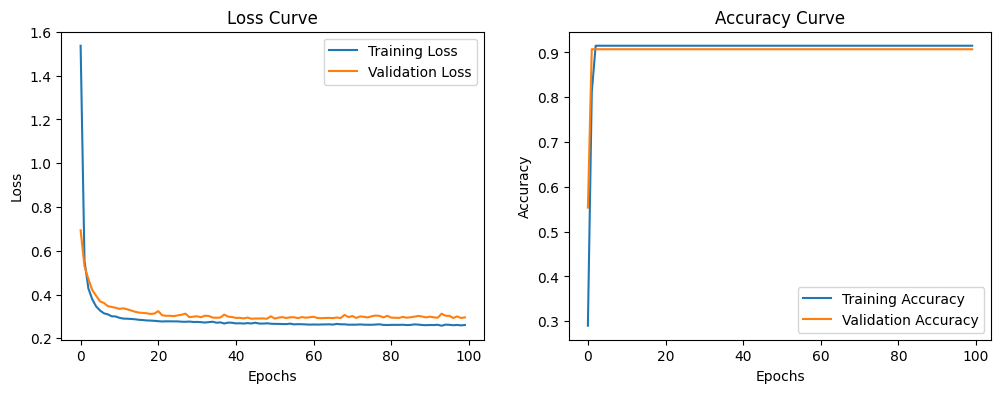 -->
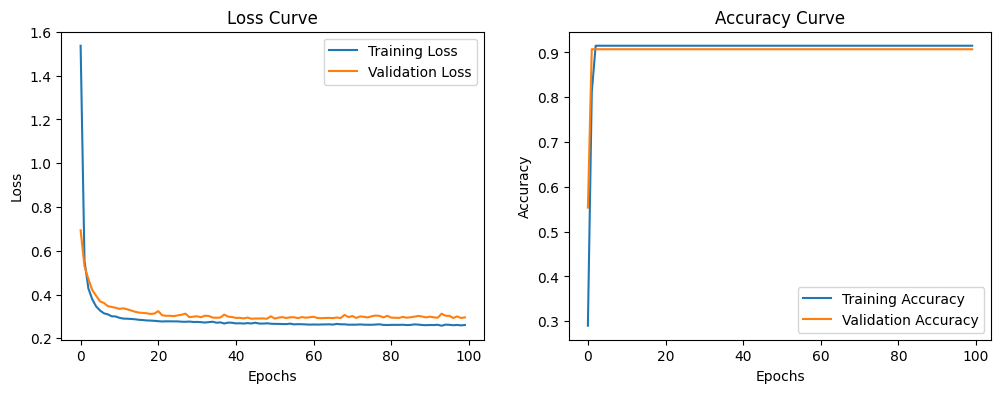

It can be observed that the classifier trained by this model demonstrates high accuracy and a low loss value.

The final model predicts the probability of countries that have not previously won a medal winning a medal in the next event. The results are shown in the figure below. ***Since many countries have a probability close to zero, only the top 10 countries most likely to win their first medal are displayed.***

![The top 10 countries most probable to win first medal.png](<attachment:The top 10 countries most probable to win first medal.png>)
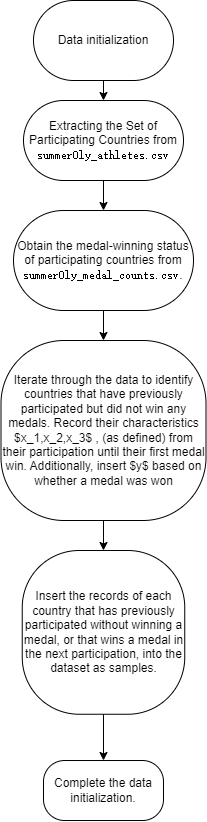
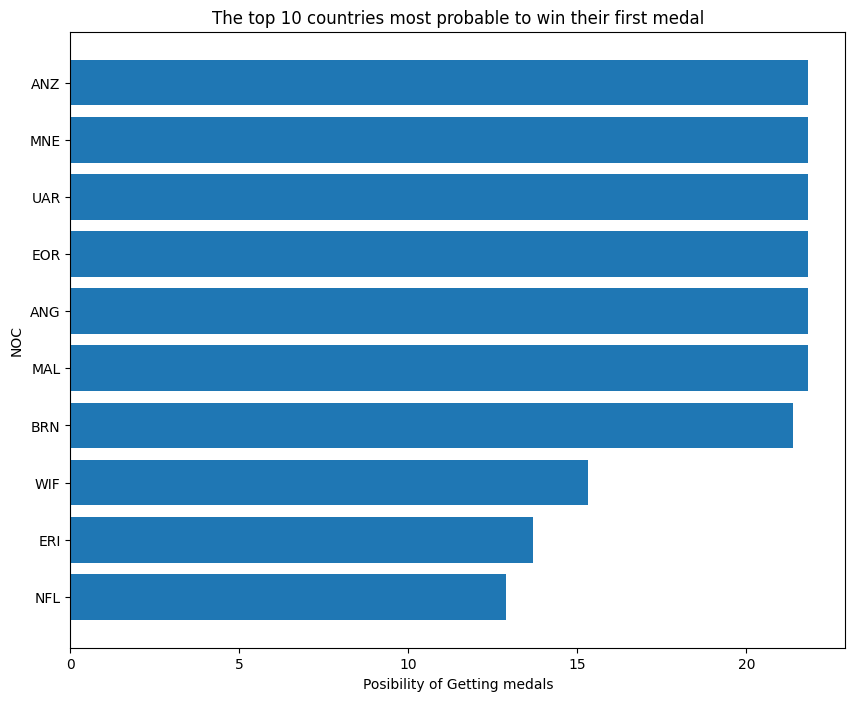

In [217]:
## C_2目标：没得奖的下一届有多大概率得奖
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [218]:
# 为了能得到样本，我们需要得到当前届每个国家参赛以来的获奖情
# 况以及每一届的运动员数量和当前届的平均项目数量
# 建立样本变量x
x = [[], [], []]  # 后续通过插入进行样本插入
Y = []

In [219]:
def get_ENAS() -> dict:
    programs_data = pd.read_csv("programs_data.csv")
    ENAS = {}
    for y in range(1896, 2025):
        try:
            val = programs_data[str(y)].values
        except:
            continue
        for i in range(len(val)):
            try:
                val[i] = int(val[i])
            except:
                val[i] = 0
        # print(y,val)
        val = np.array(val, dtype="int")
        val = val[val > 0]
        ENAS[y] = val.mean()
    return ENAS


# 得到每一届的项目平均数量
ENAS = get_ENAS()
ENAS

{1896: 8.23076923076923,
 1900: 9.44,
 1904: 10.666666666666666,
 1908: 9.535714285714286,
 1912: 11.238095238095237,
 1920: 11.34375,
 1924: 11.23076923076923,
 1928: 10.956521739130435,
 1932: 11.652173913043478,
 1936: 10.785714285714286,
 1948: 12.0,
 1952: 13.0,
 1956: 13.153846153846153,
 1960: 13.076923076923077,
 1964: 13.214285714285714,
 1968: 14.296296296296296,
 1972: 14.161290322580646,
 1976: 14.8,
 1980: 15.133333333333333,
 1984: 15.375,
 1988: 15.529411764705882,
 1992: 15.486486486486486,
 1996: 15.1,
 2000: 15.511627906976743,
 2004: 15.55813953488372,
 2008: 14.955555555555556,
 2012: 15.581395348837209,
 2016: 15.155555555555555,
 2020: 14.358490566037736,
 2024: 14.470588235294118}

In [220]:
# 导入奖牌榜
counts_data = pd.read_csv("counts_data.csv")
# 导入运动员榜
athletes_data = pd.read_csv("athletes_data.csv")
# 这两个榜单都是从data.ipynb运行导出的csv文件

In [221]:
# 获得一共有哪些国家参加过比赛
NOC_list = set(list(athletes_data["NOC"]))
# 获得最后一场比赛依然没有获奖的国家以及它最后一场比赛的三个参数
noc_o_list = dict()
# 对于每一个国家，获得它自参赛以来的每一届获奖数量
counts_year_g = counts_data.groupby("Year")
athletes_noc_g = athletes_data.groupby("NOC")
for noc in NOC_list:
    # 得到这个国家参加过哪届比赛
    athletes_noc_data = athletes_noc_g.get_group(noc)
    p_year = set(list(athletes_noc_data["Year"]))
    p_year = list(p_year)
    p_year = sorted(p_year)
    # 设立奖牌列表
    medalcount_list = []
    # 设立运动员数量列表
    athletes_num_list = []
    # 遍历得到这个国家参赛的每一届获奖数据以及每一年的远动员数量
    for p in p_year:
        if p == 1906:
            continue
        # 得到p年的获奖榜单
        tem = counts_year_g.get_group(p)
        # 得到p年的运动员名单
        p_athletes = athletes_noc_data.groupby("Year")
        p_athletes = p_athletes.get_group(p)
        # 查找是否有noc这个国家，有则插入Toal否则0
        _noc_list = tem["NOC"].values
        if noc not in _noc_list:
            medalcount_list.append(0)
        else:
            medalcount_list.append(tem["Total"][tem["NOC"] == noc].values[0])
        # 得到运动员的数量
        athletes_num = len(set(list(p_athletes["Name"])))
        athletes_num_list.append(athletes_num)
    # 判断这个国家是否能成为样本
    # 条件：首次比赛不能拿奖
    try:
        if medalcount_list[0] != 0:
            continue
    except:
        print(f"appear error country:{noc}")
        print(f"medalcount_list={medalcount_list}")
        print(f"p_year={p_year}")
        continue
    # 记录当前未拿奖的次数x_1
    x_1 = [1]
    try:
        if medalcount_list[1] == 0:
            y = [0]
        else:
            y = [1]
    except:
        pass
    for num in medalcount_list[2:]:
        if num == 0:
            x_1.append(x_1[-1] + 1)
            y.append(0)
        else:
            x_1.append(x_1[-1] + 1)
            y.append(1)
            break
    # 记录前len(x_1)届的运动员数量
    x_2 = athletes_num_list[0 : len(x_1)]
    x_2 = np.array(x_2)
    # 获得前len(x_1)届的平均运动项目数量
    x_3 = [0.0] * len(x_1)
    for i in range(len(x_1)):
        try:
            x_3[i] = ENAS[p_year[i]]
        except:
            x_3[i] = 10
    # 判断是不是从未获得过奖项
    if y[-1] == 0:
        noc_o_list[noc] = [x_1[-1], x_2[-1], x_3[-1]]
    # print(f"x_1={x_1},\nx_2={x_2},\nx_3={x_3}")
    for i in range(len(x_1)):
        try:
            x[0].append(x_1[i])
            x[1].append(x_2[i])
            x[2].append(x_3[i])
            Y.append(y[i])
        except:
            print(f"i={i}")

appear error country:CRT
medalcount_list=[]
p_year=[1906]


In [222]:
x = np.array(x)
Y = np.array(Y)
x = x.T
y1 = Y[Y == 1]
x1 = x[Y == 1]
y0 = Y[Y == 0]
x0 = x[Y == 0]
num = len(y0)
indices = np.random.randint(0, num, len(y1))
x0 = x0[indices]
y0 = y0[indices]
x = np.vstack((x1, x0))
Y = np.hstack((y1, y0))
print(f"x.shape={x.shape},Y.shape={Y.shape}")

x.shape=(230, 3),Y.shape=(230,)


In [223]:
# 接下来进行学习：
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# from sklearn.metrics import f1_score
# from tensorflow.keras.callbacks import Callback
from sklearn.utils.class_weight import compute_class_weight


def f1_score(y_true, y_pred):
    # 确保数据类型一致
    y_true = tf.cast(y_true, dtype=tf.float32)  # 转换 y_true 为 float32
    y_pred = tf.round(y_pred)  # 将 y_pred 转换为二分类值
    y_pred = tf.cast(y_pred, dtype=tf.float32)  # 确保 y_pred 为 float32

    tp = tf.reduce_sum(tf.cast(y_true * y_pred, "float"), axis=0)  # True Positives
    fp = tf.reduce_sum(
        tf.cast((1 - y_true) * y_pred, "float"), axis=0
    )  # False Positives
    fn = tf.reduce_sum(
        tf.cast(y_true * (1 - y_pred), "float"), axis=0
    )  # False Negatives

    precision = tp / (tp + fp + tf.keras.backend.epsilon())  # 避免除零
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return tf.reduce_mean(f1)


# 构建模型
model = Sequential(
    [
        Dense(4, input_dim=3, activation="sigmoid"),  # 输入层和第1隐藏层
        Dense(4, activation="sigmoid"),  # 第2隐藏层
        Dense(1, activation="sigmoid"),  # 输出层，用于概率预测
    ]
)

# 编译模型
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", f1_score],  # 二分类问题
)

# 模型概览
model.summary()

X_train = x
y_train = Y

# class_weights = compute_class_weight("balanced", classes=np.array([0, 1]), y=y_train)
# 训练模型
# epochs模型迭代次数
# batch_size样本分组16组
# validation_split测试训练集合比
# 回调函数设置为计算F1分数函数
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
)

c:\Users\22230\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_65 (Dense)                │ (None, 4)                 │         16 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_66 (Dense)                │ (None, 4)                 │         20 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_67 (Dense)                │ (None, 1)                 │          5 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3964 - f1_score: 0.0000e+00 - loss: 0.7858 - val_accuracy: 1.0000 - val_f1_score: 0.0000e+00 - val_loss: 0.4977
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3469 - f1_score: 0.0000e+00 - loss: 0.7940 - val_accuracy: 1.0000 - val_f1_score: 0.0000e+00 - val_loss: 0.5166
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3562 - f1_score: 0.0000e+00 - loss: 0.7846 - val_accuracy: 1.0000 - val_f1_score: 0.0000e+00 - val_loss: 0.5346
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3993 - f1_score: 0.0000e+00 - loss: 0.7559 - val_accuracy: 1.0000 - val_f1_score: 0.0000e+00 - val_loss: 0.5517
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3381 - f1_score: 0.0000e+00 - loss: 0.7640 - val_accuracy: 1.0000 - val_f1_score: 0.0000e+00 - val_loss: 0.5706
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3688 - f1_score: 0.0000e+00 - loss: 0.7487 - val_

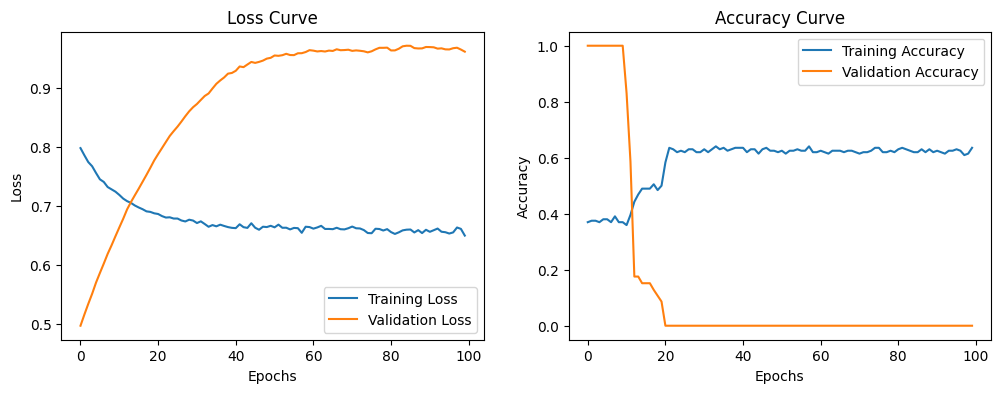

In [224]:
# 提取历史记录
loss = history.history["loss"]  # 训练损失
val_loss = history.history["val_loss"]  # 验证损失
accuracy = history.history["accuracy"]  # 训练准确率
val_accuracy = history.history["val_accuracy"]  # 验证准确率

# 绘制学习曲线：损失
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# 绘制学习曲线：准确率
plt.subplot(1, 2, 2)
plt.plot(accuracy, label="Training Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()

In [225]:
print(noc_o_list)

{'BIH': [8, 7, 14.358490566037736], 'DJI': [9, 4, 14.358490566037736], 'BEN': [12, 7, 14.358490566037736], 'CAY': [11, 5, 14.358490566037736], 'AIN': [1, 32, 14.470588235294118], 'RSA': [20, 181, 14.358490566037736], 'LBN': [1, 6, 14.358490566037736], 'AHO': [12, 3, 15.55813953488372], 'LIE': [18, 5, 14.358490566037736], 'NCA': [13, 8, 14.358490566037736], 'VAN': [9, 3, 14.358490566037736], 'PLW': [6, 3, 14.358490566037736], 'CAM': [10, 3, 14.358490566037736], 'COM': [7, 3, 14.358490566037736], 'MTN': [10, 2, 14.358490566037736], 'ISV': [13, 4, 14.358490566037736], 'MLI': [14, 4, 14.358490566037736], 'LAO': [10, 4, 14.358490566037736], 'PLE': [7, 5, 14.358490566037736], 'KIR': [5, 3, 14.358490566037736], 'MDV': [9, 4, 14.358490566037736], 'AND': [12, 2, 14.358490566037736], 'GBS': [7, 4, 14.358490566037736], 'IRQ': [15, 3, 14.358490566037736], 'MAW': [11, 5, 14.358490566037736], 'PNG': [11, 8, 14.358490566037736], 'UAR': [1, 74, 13.076923076923077], 'NFL': [1, 1, 10.666666666666666], '

In [226]:
# 进行2028年的预测
# 得到如今依旧没有获奖的国家
# 预测每个国家的拿奖概率
noc_o_p = dict()
for i in noc_o_list.keys():
    # print(noc_o_list[i])
    x = noc_o_list[i]
    x = np.array(x)
    x = x.reshape((1, 3))
    ans = model.predict(x)
    # 百分化
    noc_o_p[i] = ans[0][0] * 100
noc_o_p

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

{'BIH': 60.99119782447815,
 'DJI': 60.74134111404419,
 'BEN': 61.31947040557861,
 'CAY': 60.86150407791138,
 'AIN': 64.13140296936035,
 'RSA': 64.15201425552368,
 'LBN': 60.715252161026,
 'AHO': 60.71066856384277,
 'LIE': 61.47034168243408,
 'NCA': 61.90909147262573,
 'VAN': 60.710400342941284,
 'PLW': 60.68611145019531,
 'CAM': 60.723090171813965,
 'COM': 60.69241762161255,
 'MTN': 60.70047616958618,
 'ISV': 60.85277199745178,
 'MLI': 60.89969277381897,
 'LAO': 60.760653018951416,
 'PLE': 60.75087785720825,
 'KIR': 60.681092739105225,
 'MDV': 60.74134111404419,
 'AND': 60.725051164627075,
 'GBS': 60.713547468185425,
 'IRQ': 60.85789203643799,
 'MAW': 60.86150407791138,
 'PNG': 61.58367395401001,
 'UAR': 64.15201425552368,
 'NFL': 60.68832874298096,
 'OMA': 60.760653018951416,
 'SOL': 60.723090171813965,
 'ANG': 64.46131467819214,
 'SSD': 60.66662073135376,
 'GUI': 60.90703010559082,
 'FSM': 60.68611145019531,
 'BRN': 64.15029764175415,
 'MLT': 61.659181118011475,
 'BAN': 60.9352469444

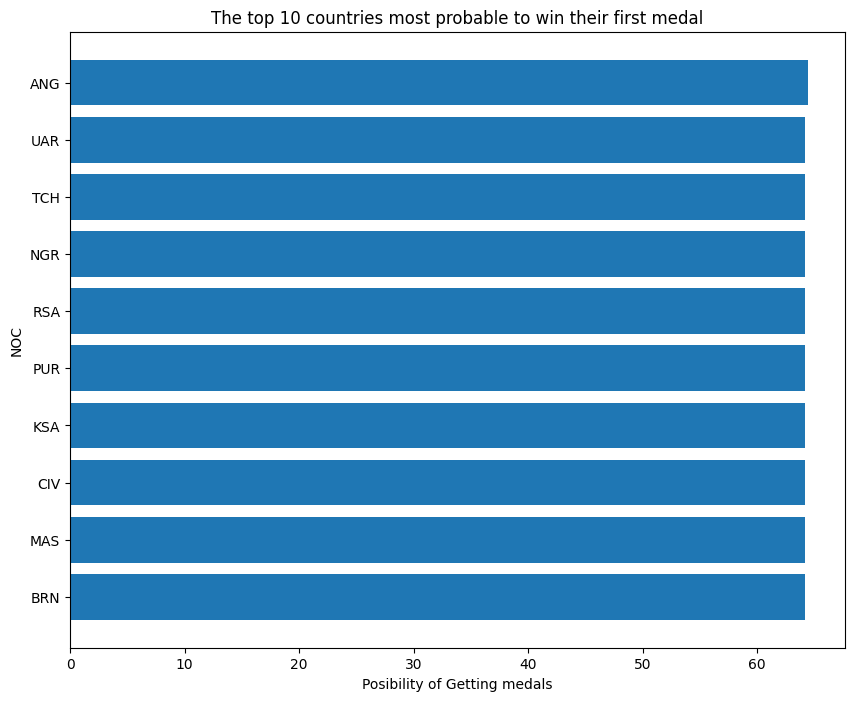

In [227]:
o_p = [noc_o_p[i] for i in noc_o_p.keys()]
o_p = np.array(o_p)
noc_o = list(noc_o_list.keys())
noc_o = np.array(noc_o)
indices = np.argsort(o_p)
show_indices = indices[::-1][0:10]
try:
    plt.figure(figsize=(10, 8))
    plt.title("The top 10 countries most probable to win their first medal")
    plt.barh(noc_o[show_indices], [noc_o_p[i] for i in noc_o[show_indices]])
    plt.gca().invert_yaxis()
    plt.ylabel("NOC")
    plt.xlabel("Posibility of Getting medals")
    plt.show()

except:
    print(show_indices)
    print(noc_o[show_indices])